# **Pretrain a TF model to imitate federated learning**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-05-07 15:02:21.314847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 15:02:21.314881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 15:02:21.315529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 15:02:21.319502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 15:02:21.953704: W tensorflow/compiler/tf2

In [3]:
import json

In [4]:
RESULTS_ROOT = "../01_simulation/04_results/"
SEEDS = ['42', '1234', '1867', '613', '1001']

In [5]:
p_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = RESULTS_ROOT+f'poccup_by_vehs_{s}.csv'
    pf = pd.read_csv(filename)
    pf["seed"] = [s]*len(pf)
    p_data = pd.concat([p_data, pf])
    

In [6]:
def combine_commuters(veh_id):
    if veh_id.startswith("carIn"):
        return veh_id.split(":")[0]
    return veh_id

In [7]:
p_data["veh_id"] = p_data["veh_id"].apply(combine_commuters)

In [8]:
len(p_data["veh_id"].unique())

4644

In [9]:
parkings = p_data["parking_id"].unique()

In [10]:
p_data = pd.get_dummies(p_data, columns=["parking_id"])
p_data["time"] = p_data["time"] - 4*24*60*60
p_data["time"] = p_data["time"].astype(int)
p_data["time_of_day"] = (p_data["time"] - (p_data["time"] // (24*60*60))*24*60*60) / (24*60*60) #converting to 0.0-1.0 and removing periodicity

In [11]:
column_dict = {}
for_columns_data = p_data.head()
for_columns_data = for_columns_data.drop(columns=["veh_id", "time", "occupancy", "seed", "occupancy"])
cols = list(for_columns_data.columns)
for p in parkings:
    column_dict[p] = cols.index(f"parking_id_{p}")

In [12]:
with open("one_hot_encoding_dict.json", "w") as f:
    json.dump(column_dict, f)

## Create vehicle list

In [13]:
vehicles = np.random.choice(p_data["veh_id"].unique(), 4300, replace=False) #out of 4644 vehicles
test_vehicles = np.random.choice(p_data[~p_data["veh_id"].isin(vehicles)]["veh_id"].unique(), 300, replace=False)

In [14]:
# save the list of selected vehicles:
import json

save_vehs = {
    "train_vehs": list(vehicles),
    "test_vehs" : list(test_vehicles)
}
with open("veh_list.json", "w") as f:
    json.dump(save_vehs, f)

## Load vehicle list

In [13]:
#loading the list selected vehicles:
with open("veh_list.json", "r") as f:
    saved_vehs = json.load(f)
vehicles = saved_vehs["train_vehs"]

## Training

In [14]:
p_train = p_data[p_data["veh_id"].isin(vehicles)]

In [15]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001))
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)]

2024-05-07 15:02:42.846301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 15:02:42.870395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 15:02:42.870560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
X_train = p_train.drop(columns=["veh_id", "time", "occupancy", "seed"])
y_train = p_train["occupancy"]

In [17]:
train_indices = np.random.randint(0, len(X_train), 1000000)
x_train_batch = X_train.iloc[train_indices]
y_train_batch = y_train.iloc[train_indices]
history = model.fit(x=x_train_batch, y=y_train_batch, epochs=5, batch_size=10000, callbacks=callbacks)
while len(history.history["loss"])%5 == 0:
    history = model.fit(x=x_train_batch, y=y_train_batch, epochs=5, batch_size=10000, callbacks=callbacks)

Epoch 1/5


2024-05-07 15:02:46.309767: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-07 15:02:46.581040: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9c51e08440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-07 15:02:46.581063: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-07 15:02:46.584390: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-07 15:02:46.595270: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1715086966.659521   14897 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 2s 4ms/step - loss: 0.0740
Epoch 2/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 3/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 4/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 5/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 1/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 2/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 3/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 4/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 5/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 1/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 2/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 3/5
100/100 [==============================]

2024-05-07 15:03:21.144328: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 39.1KiB (rounded to 40192)requested by op SameWorkerRecvDone
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-05-07 15:03:21.144361: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-05-07 15:03:21.144374: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 34, Chunks in use: 32. 8.5KiB allocated for chunks. 8.0KiB in use in bin. 2.4KiB client-requested in use in bin.
2024-05-07 15:03:21.144384: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 3, Chunks in use: 3. 1.5KiB allocated for chunks. 1.5KiB in use in bin. 1.5KiB client-requested in use in bin.
2024-05-07 15:03:21.144

ResourceExhaustedError: Graph execution error:

Detected at node IteratorGetNext/_4 defined at (most recent call last):
<stack traces unavailable>
SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;7ebecea1c9fbb9e1;/job:localhost/replica:0/task:0/device:GPU:0;edge_31_IteratorGetNext;0:0
	 [[{{node IteratorGetNext/_4}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1015]

## **Checking**

In [21]:
p_data

,veh_id,time,occupancy,seed,parking_id_pa-109,parking_id_pa-11,parking_id_pa-120,parking_id_pa-123,parking_id_pa-131,parking_id_pa-144,...,parking_id_pa55,parking_id_pa58,parking_id_pa60,parking_id_pa64,parking_id_pa68,parking_id_pa71,parking_id_pa75,parking_id_pa79,parking_id_pa92,time_of_day
0,h3098c1:0,10,0.923077,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000116
1,h3098c1:0,10,0.842105,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000116
2,h3098c1:0,10,0.769231,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000116
3,h3098c1:0,11,0.923077,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000127
4,h3098c1:0,11,0.842105,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128768,h798c1:0,432000,0.000000,1001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3128769,h798c1:0,432000,0.750000,1001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3128770,h3101c1:0,432000,0.428571,1001,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3128771,h3101c1:0,432000,0.000000,1001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [22]:
#PARKING = "pa184"
PARKING = "pa-71"

In [23]:
parking_data = p_data[p_data[f"parking_id_{PARKING}"] == 1]
vis_data = parking_data.groupby("time_of_day")["occupancy"].mean()

In [24]:
t = np.arange(0, 1, 1/(24*60*60))

In [25]:
one_hot = parking_data.drop(columns=["veh_id", "time", "occupancy", "seed", "time_of_day"]).iloc[0]
one_hot = [one_hot.values]*len(t)

In [26]:
pred_x = np.array(one_hot)

In [27]:
pred_x = pd.DataFrame(pred_x)
pred_x["t"] = t

In [28]:
preds = model.predict(pred_x, batch_size=200)

432/432 [==============================] - 0s 638us/step


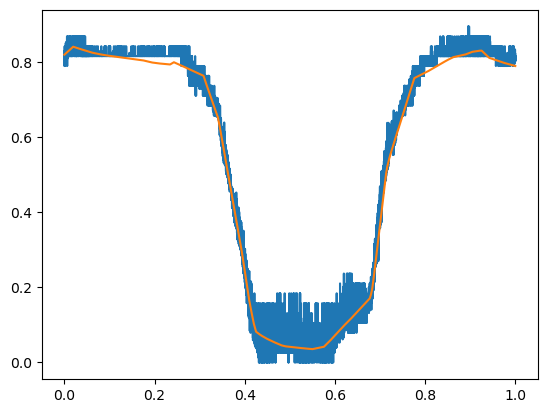

In [29]:
plt.plot(vis_data)
plt.plot(t, preds)

In [30]:
model.save("saved_models/pretrained")

INFO:tensorflow:Assets written to: saved_models/pretrained/assets
